### Lagrangian diagnostics from filtered and demodulated signal
cf github/zcasparco/equinox_phd/llc4320/signal_filtering_storeL.ipynb for filtering and demodulation method

1) Quick first look at instanteanous diagnostics : phase and amplitude

2) Compute Lagrangian autocovariance of demodulated signal

In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.8577857.datarmor0/parcels-502090/libparcels_random_f2675e3f-f0df-4889-8056-d200f6624ba3.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=10
                 )
#
client = Client(cluster)

In [3]:
# Load Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'

#run_name_old = 'global_extra_T365j_dt1j_dij50'
parcels_index = 'filtered_itide_Tw30_sd_band04'

# choose to select time indexed data for now
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df = p[parcels_index]
df = pa.degs2ms(df)
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,dt_flag,zonal_velocity_hat_real,zonal_velocity_hat_imag,zonal_velocity_demodulated_real,zonal_velocity_demodulated_imag,meridional_velocity_hat_real,meridional_velocity_hat_imag,meridional_velocity_demodulated_real,meridional_velocity_demodulated_imag
time,,,,,,,,,,,,,,,,,,
2011-11-15,2000180,-69.537819,-27.562500,0.0,0.0,0.0,0.0,0.0,0.0,False,0.003860,0.000828,0.003860,0.000828,0.001959,0.004701,0.001959,0.004701
2011-11-15,32001633,-68.398026,-111.145836,0.0,0.0,0.0,0.0,0.0,0.0,False,0.010257,-0.006823,0.010257,-0.006823,0.006176,-0.005051,0.006176,-0.005051
2011-11-15,33000001,-60.259064,-178.854172,0.0,0.0,0.0,0.0,0.0,0.0,False,-0.018617,-0.000236,-0.018617,-0.000236,-0.002741,-0.001225,-0.002741,-0.001225
2011-11-15,33000332,-57.061897,-165.312500,0.0,0.0,0.0,0.0,0.0,0.0,False,-0.005545,-0.002806,-0.005545,-0.002806,-0.020069,0.000412,-0.020069,0.000412
2011-11-15,33001023,-47.411320,-137.187500,0.0,0.0,0.0,0.0,0.0,0.0,False,-0.011063,-0.002011,-0.011063,-0.002011,-0.002488,0.009116,-0.002488,0.009116


### Instantaneous (phase and amplitude)

In [4]:
# Reconstruct the complex demodulated analytic signal
v = 'zonal_velocity'
df[v+'_demodulated'] = (df[v+'_demodulated_real']+1j*df[v+'_demodulated_imag']).persist()
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,dt_flag,zonal_velocity_hat_real,zonal_velocity_hat_imag,zonal_velocity_demodulated_real,zonal_velocity_demodulated_imag,meridional_velocity_hat_real,meridional_velocity_hat_imag,meridional_velocity_demodulated_real,meridional_velocity_demodulated_imag,zonal_velocity_demodulated
time,,,,,,,,,,,,,,,,,,,
2011-11-15,2000180,-69.537819,-27.562500,0.0,0.0,0.0,0.0,0.0,0.0,False,0.003860,0.000828,0.003860,0.000828,0.001959,0.004701,0.001959,0.004701,0.003860+0.000828j
2011-11-15,32001633,-68.398026,-111.145836,0.0,0.0,0.0,0.0,0.0,0.0,False,0.010257,-0.006823,0.010257,-0.006823,0.006176,-0.005051,0.006176,-0.005051,0.010257-0.006823j
2011-11-15,33000001,-60.259064,-178.854172,0.0,0.0,0.0,0.0,0.0,0.0,False,-0.018617,-0.000236,-0.018617,-0.000236,-0.002741,-0.001225,-0.002741,-0.001225,-0.018617-0.000236j
2011-11-15,33000332,-57.061897,-165.312500,0.0,0.0,0.0,0.0,0.0,0.0,False,-0.005545,-0.002806,-0.005545,-0.002806,-0.020069,0.000412,-0.020069,0.000412,-0.005545-0.002806j
2011-11-15,33001023,-47.411320,-137.187500,0.0,0.0,0.0,0.0,0.0,0.0,False,-0.011063,-0.002011,-0.011063,-0.002011,-0.002488,0.009116,-0.002488,0.009116,-0.011063-0.002011j


In [5]:
#binsize = 2
lonmin,lonmax = np.around(df.lon.min().compute()),np.around(df.lon.max().compute())
latmin,latmax = np.around(df.lat.min().compute()),np.around(df.lat.max().compute())
#lon_bins,lat_bins = np.arange(lonmin,lonmax,binsize),np.arange(latmin,latmax,binsize)

In [6]:
# Compute phase and amplitude of the filtered and demodulated analytic signal
df[v+'_demodulated_phase'] = df[v+'_demodulated'].apply(lambda x : np.angle(x))
df[v+'_demodulated_ampl'] = df[v+'_demodulated'].apply(lambda x : np.abs(x))

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3522: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('zonal_velocity_demodulated', 'float64'))

  warnings.warn(meta_warning(meta))


In [7]:
_df = df[df.trajectory==37000596].compute()

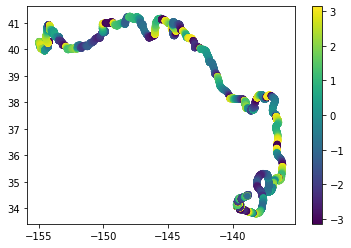

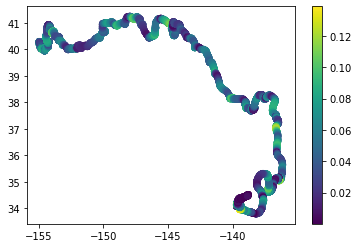

In [8]:
im = plt.scatter(_df.lon,_df.lat,c=_df[v+'_demodulated_phase'])
plt.colorbar(im)
plt.figure()
im = plt.scatter(_df.lon,_df.lat,c=_df[v+'_demodulated_ampl'])
plt.colorbar(im)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


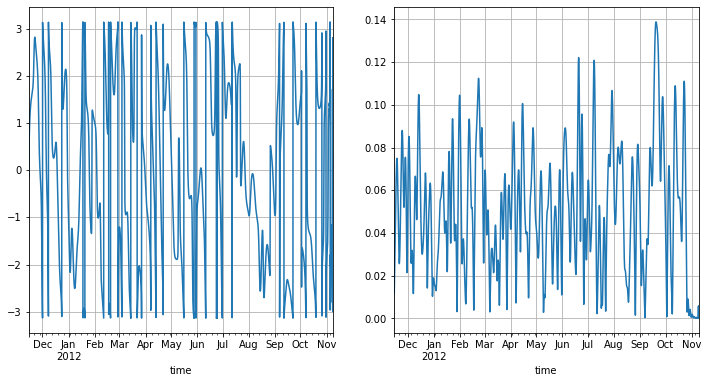

In [14]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
_df.zonal_velocity_demodulated_phase.plot(ax=axs[0])
_df.zonal_velocity_demodulated_ampl.plot(ax=axs[1])
for ax in axs:
    ax.grid()

### Compute autocovariance

In [15]:
def time_window_processing(df, myfun, columns, T, N, overlap=0.5, **myfun_kwargs):
    ''' break each drifter time series into time windows and process each windows
    
    Parameters
    ----------
        
        df: Dataframe
            This dataframe represents a drifter time series
        
        T: float
            Length of the time windows
            
        myfun
            Method that will be applied to each window
            
        columns: list of str
            List of columns of df that will become inputs of myfun
            
        N: int
            Length of myfun outputs
            
        L: int
            Maximum x (used in mean_position)
            
        overlap: float
            Amount of overlap between windows. 
            Should be between 0 and 1. 
            Default is 0.5
            
        **myfun_kwargs
            Keyword arguments for myfun
    
    '''
    if hasattr(df, 'trajectory'):
        dr_id = df.trajectory.unique()[0]
    elif df.index.name=='trajectory':
        dr_id = df.index.unique()[0]
    elif hasattr(df, 'name'):
        # when mapped after groupby
        dr_id = df.name
    else:
        assert False, 'Cannot find float id'
    #
    _df = df.sort_values('time')#.set_index('time')
    time_float = [float(i)/(3600*1e9*24) for i in _df.time.values[:]-_df.time.values[0]]
    _df['time_float'] = time_float
    _df = _df.set_index('time_float')
    tmin, tmax = _df.index[0], _df.index[-1]
    # need to create an empty dataframe, in case the loop below is empty
    myfun_out = myfun(*[None for c in columns], N, **myfun_kwargs) # get index from fake output
    index = ['lon','lat']+['id']+list(myfun_out.index)
    out = [pd.DataFrame({_:[] for _ in index})]
    t=tmin
    while t+T<tmax:
        #
        _p = _df.loc[t:t+T]
        # compute average position
        x, y = _p.lon.mean(),_p.lat.mean()#mean_position(_p, L)
        # apply myfun
        myfun_out = myfun(*[_p[c] for c in columns], N, **myfun_kwargs)
        # combine with mean position and time
        _out = pd.DataFrame([[x, y]+[dr_id]+list(myfun_out)],
                            columns = index,
                            index = [t+T/2.])
        out.append(_out)
        t+=T*(1-overlap)
    return pd.concat(out)

def correlate(v1, v2, N, detrend = False, dt=None):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v1, v2: ndarray, pd.Series
            Time series to correlate, the index must be time if dt is not Provided
            
        N: int
            Length of the output
            
        dt: float, optional
            Time step
            
        detrend: boolean, optional
            Turns detrending on or off. Default is False.

    See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
    '''
    if dt is None:
        dt = v1.reset_index()['index'].diff().mean()
    
    if v1 is None and v2 is None:
        _v1 = np.random.randn(N)
        _v2 = np.random.randn(N)
        vv = np.correlate(_v1[N//2:], _v2, mode='valid')
    else:
        if detrend:
            _v1 = v1
            _v2 = v2
            v1 = signal.detrend(v1)
            v2 = signal.detrend(v2)
        #print('!!! Not implemented yet')
        # https://www.machinelearningplus.com/time-series/time-series-analysis-python/
        
        vv = np.correlate(v1.iloc[N//2:], v2, mode='valid')/(N/2)
    out = vv[:][:N]
    index=list(np.arange(N//2+1)*dt)
    return pd.Series(out,index=index)

In [16]:
def wrap_correlate(df,columns,T,N,dt,binsize):
    """Wrap the correlation computation functions
    """
    df_chunked = df.groupby(df.index).apply(time_window_processing,correlate,columns,T,N,dt=dt).persist()
    df_chunked = df_chunked.reset_index().rename(columns={'level_1': 'time'})
    lon_bins,lat_bins = np.arange(lonmin,lonmax,binsize),np.arange(latmin,latmax,binsize)
    x_idx,y_idx = pd.IntervalIndex.from_breaks(lon_bins),pd.IntervalIndex.from_breaks(lat_bins)
    df_chunked['lon_cut'] = df_chunked['lon'].map_partitions(pd.cut, bins=lon_bins)
    df_chunked['lat_cut'] = df_chunked['lat'].map_partitions(pd.cut, bins=lat_bins)
    return df_chunked

In [17]:
dt = 1/24
T=80
N=int(T/dt)

In [18]:
df = df.reset_index().set_index('trajectory').persist()

In [19]:
# real-real autocovariance
v1,v2 = 'zonal_velocity_demodulated_real','zonal_velocity_demodulated_real'
df_autocorr_rr = wrap_correlate(df,[v1,v2],T,N,dt,binsize=2)
df_autocorr_rr

<ipython-input-16-90dbed929125>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_chunked = df.groupby(df.index).apply(time_window_processing,correlate,columns,T,N,dt=dt).persist()


,trajectory,time,lon,lat,id,0.0,0.041666666666666664,0.08333333333333333,0.125,0.16666666666666666,0.20833333333333331,0.25,0.29166666666666663,0.3333333333333333,0.375,0.41666666666666663,0.4583333333333333,0.5,0.5416666666666666,0.5833333333333333,0.625,0.6666666666666666,0.7083333333333333,0.75,0.7916666666666666,0.8333333333333333,0.875,0.9166666666666666,0.9583333333333333,1.0,1.0416666666666665,1.0833333333333333,1.125,1.1666666666666665,1.2083333333333333,1.25,1.2916666666666665,1.3333333333333333,1.375,1.4166666666666665,1.4583333333333333,1.5,1.5416666666666665,1.5833333333333333,1.625,1.6666666666666665,1.7083333333333333,1.75,1.7916666666666665,1.8333333333333333,1.875,1.9166666666666665,1.9583333333333333,2.0,2.0416666666666665,2.083333333333333,2.125,2.1666666666666665,2.208333333333333,2.25,2.2916666666666665,2.333333333333333,2.375,2.4166666666666665,2.458333333333333,2.5,2.5416666666666665,2.583333333333333,2.625,2.6666666666666665,2.708333333333333,2.75,2.7916666666666665,2.833333333333333,2.875,2.9166666666666665,2.958333333333333,3.0,3.0416666666666665,3.083333333333333,3.125,3.1666666666666665,3.208333333333333,3.25,3.2916666666666665,3.333333333333333,3.375,3.4166666666666665,3.458333333333333,3.5,3.5416666666666665,3.583333333333333,3.625,3.6666666666666665,3.708333333333333,3.75,3.7916666666666665,3.833333333333333,3.875,3.9166666666666665,3.958333333333333,4.0,4.041666666666666,4.083333333333333,4.125,4.166666666666666,4.208333333333333,4.25,4.291666666666666,4.333333333333333,4.375,4.416666666666666,4.458333333333333,4.5,4.541666666666666,4.583333333333333,4.625,4.666666666666666,4.708333333333333,4.75,4.791666666666666,4.833333333333333,4.875,4.916666666666666,4.958333333333333,5.0,5.041666666666666,5.083333333333333,5.125,5.166666666666666,5.208333333333333,5.25,5.291666666666666,5.333333333333333,5.375,5.416666666666666,5.458333333333333,5.5,5.541666666666666,5.583333333333333,5.625,5.666666666666666,5.708333333333333,5.75,5.791666666666666,5.833333333333333,5.875,5.916666666666666,5.958333333333333,6.0,6.041666666666666,6.083333333333333,6.125,6.166666666666666,6.208333333333333,6.25,6.291666666666666,6.333333333333333,6.375,6.416666666666666,6.458333333333333,6.5,6.541666666666666,6.583333333333333,6.625,6.666666666666666,6.708333333333333,6.75,6.791666666666666,6.833333333333333,6.875,6.916666666666666,6.958333333333333,7.0,7.041666666666666,7.083333333333333,7.125,7.166666666666666,7.208333333333333,7.25,7.291666666666666,7.333333333333333,7.375,7.416666666666666,7.458333333333333,7.5,7.541666666666666,7.583333333333333,7.625,7.666666666666666,7.708333333333333,7.75,7.791666666666666,7.833333333333333,7.875,7.916666666666666,7.958333333333333,8.0,8.041666666666666,8.083333333333332,8.125,8.166666666666666,8.208333333333332,8.25,8.291666666666666,8.333333333333332,8.375,8.416666666666666,8.458333333333332,8.5,8.541666666666666,8.583333333333332,8.625,8.666666666666666,8.708333333333332,8.75,8.791666666666666,8.833333333333332,8.875,8.916666666666666,8.958333333333332,9.0,9.041666666666666,9.083333333333332,9.125,9.166666666666666,9.208333333333332,9.25,9.291666666666666,9.333333333333332,9.375,9.416666666666666,9.458333333333332,9.5,9.541666666666666,9.583333333333332,9.625,9.666666666666666,9.708333333333332,9.75,9.791666666666666,9.833333333333332,9.875,9.916666666666666,9.958333333333332,10.0,10.041666666666666,10.083333333333332,10.125,10.166666666666666,10.208333333333332,10.25,10.291666666666666,10.333333333333332,10.375,10.416666666666666,10.458333333333332,10.5,10.541666666666666,10.583333333333332,10.625,10.666666666666666,10.708333333333332,10.75,10.791666666666666,10.833333333333332,10.875,10.916666666666666,10.958333333333332,11.0,11.041666666666666,11.083333333333332,11.125,11.166666666666666,11.208333333333332,11.25,11.291666666666666,11.333333333333332,11.375,11.416666666666666,11.458333333333332,11.5,11.541666666666666,11.583333333333332,11.625,11.666666666666666,11.70833333333333

In [24]:
# real-imag autocovariance
v1,v2 = 'zonal_velocity_demodulated_real','zonal_velocity_demodulated_imag'
df_autocorr_ri = wrap_correlate(df,[v1,v2],T,N,dt,binsize=2)
df_autocorr_ri

<ipython-input-16-90dbed929125>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_chunked = df.groupby(df.index).apply(time_window_processing,correlate,columns,T,N,dt=dt).persist()


,trajectory,time,lon,lat,id,0.0,0.041666666666666664,0.08333333333333333,0.125,0.16666666666666666,0.20833333333333331,0.25,0.29166666666666663,0.3333333333333333,0.375,0.41666666666666663,0.4583333333333333,0.5,0.5416666666666666,0.5833333333333333,0.625,0.6666666666666666,0.7083333333333333,0.75,0.7916666666666666,0.8333333333333333,0.875,0.9166666666666666,0.9583333333333333,1.0,1.0416666666666665,1.0833333333333333,1.125,1.1666666666666665,1.2083333333333333,1.25,1.2916666666666665,1.3333333333333333,1.375,1.4166666666666665,1.4583333333333333,1.5,1.5416666666666665,1.5833333333333333,1.625,1.6666666666666665,1.7083333333333333,1.75,1.7916666666666665,1.8333333333333333,1.875,1.9166666666666665,1.9583333333333333,2.0,2.0416666666666665,2.083333333333333,2.125,2.1666666666666665,2.208333333333333,2.25,2.2916666666666665,2.333333333333333,2.375,2.4166666666666665,2.458333333333333,2.5,2.5416666666666665,2.583333333333333,2.625,2.6666666666666665,2.708333333333333,2.75,2.7916666666666665,2.833333333333333,2.875,2.9166666666666665,2.958333333333333,3.0,3.0416666666666665,3.083333333333333,3.125,3.1666666666666665,3.208333333333333,3.25,3.2916666666666665,3.333333333333333,3.375,3.4166666666666665,3.458333333333333,3.5,3.5416666666666665,3.583333333333333,3.625,3.6666666666666665,3.708333333333333,3.75,3.7916666666666665,3.833333333333333,3.875,3.9166666666666665,3.958333333333333,4.0,4.041666666666666,4.083333333333333,4.125,4.166666666666666,4.208333333333333,4.25,4.291666666666666,4.333333333333333,4.375,4.416666666666666,4.458333333333333,4.5,4.541666666666666,4.583333333333333,4.625,4.666666666666666,4.708333333333333,4.75,4.791666666666666,4.833333333333333,4.875,4.916666666666666,4.958333333333333,5.0,5.041666666666666,5.083333333333333,5.125,5.166666666666666,5.208333333333333,5.25,5.291666666666666,5.333333333333333,5.375,5.416666666666666,5.458333333333333,5.5,5.541666666666666,5.583333333333333,5.625,5.666666666666666,5.708333333333333,5.75,5.791666666666666,5.833333333333333,5.875,5.916666666666666,5.958333333333333,6.0,6.041666666666666,6.083333333333333,6.125,6.166666666666666,6.208333333333333,6.25,6.291666666666666,6.333333333333333,6.375,6.416666666666666,6.458333333333333,6.5,6.541666666666666,6.583333333333333,6.625,6.666666666666666,6.708333333333333,6.75,6.791666666666666,6.833333333333333,6.875,6.916666666666666,6.958333333333333,7.0,7.041666666666666,7.083333333333333,7.125,7.166666666666666,7.208333333333333,7.25,7.291666666666666,7.333333333333333,7.375,7.416666666666666,7.458333333333333,7.5,7.541666666666666,7.583333333333333,7.625,7.666666666666666,7.708333333333333,7.75,7.791666666666666,7.833333333333333,7.875,7.916666666666666,7.958333333333333,8.0,8.041666666666666,8.083333333333332,8.125,8.166666666666666,8.208333333333332,8.25,8.291666666666666,8.333333333333332,8.375,8.416666666666666,8.458333333333332,8.5,8.541666666666666,8.583333333333332,8.625,8.666666666666666,8.708333333333332,8.75,8.791666666666666,8.833333333333332,8.875,8.916666666666666,8.958333333333332,9.0,9.041666666666666,9.083333333333332,9.125,9.166666666666666,9.208333333333332,9.25,9.291666666666666,9.333333333333332,9.375,9.416666666666666,9.458333333333332,9.5,9.541666666666666,9.583333333333332,9.625,9.666666666666666,9.708333333333332,9.75,9.791666666666666,9.833333333333332,9.875,9.916666666666666,9.958333333333332,10.0,10.041666666666666,10.083333333333332,10.125,10.166666666666666,10.208333333333332,10.25,10.291666666666666,10.333333333333332,10.375,10.416666666666666,10.458333333333332,10.5,10.541666666666666,10.583333333333332,10.625,10.666666666666666,10.708333333333332,10.75,10.791666666666666,10.833333333333332,10.875,10.916666666666666,10.958333333333332,11.0,11.041666666666666,11.083333333333332,11.125,11.166666666666666,11.208333333333332,11.25,11.291666666666666,11.333333333333332,11.375,11.416666666666666,11.458333333333332,11.5,11.541666666666666,11.583333333333332,11.625,11.666666666666666,11.70833333333333

In [25]:
#rr = df_autocorr_rr.groupby(['lon_cut','lat_cut']).mean().compute()
ri = df_autocorr_ri.groupby(['lon_cut','lat_cut']).mean().compute()




KeyboardInterrupt: 

#### Converting pandas dataframe in xarray dataset:

In [21]:
t = pd.melt(rr.drop(columns=['id','time','lon','lat','trajectory']).reset_index(), id_vars=['lon_cut','lat_cut'], var_name='lag')

In [22]:
ds = t.rename(columns={'lon_cut': 'lon_bins','lat_cut': 'lat_bins', 'value': 'rr'}).to_xarray()

In [23]:
ds = ds.set_index(index=['lon_bins','lat_bins','lag']).unstack()

In [22]:
ti = pd.melt(ri.drop(columns=['id','time','lon','lat','trajectory']).reset_index(),
            id_vars=['lon_cut','lat_cut'], var_name='lag')
_ds = ti.rename(columns={'lon_cut': 'lon_bins','lat_cut': 'lat_bins', 'value': 'ri'}).to_xarray()
ds['ri'] = _ds.set_index(index=['lon_bins','lat_bins','lag']).unstack().ri

Text(0.5, 1.0, '')

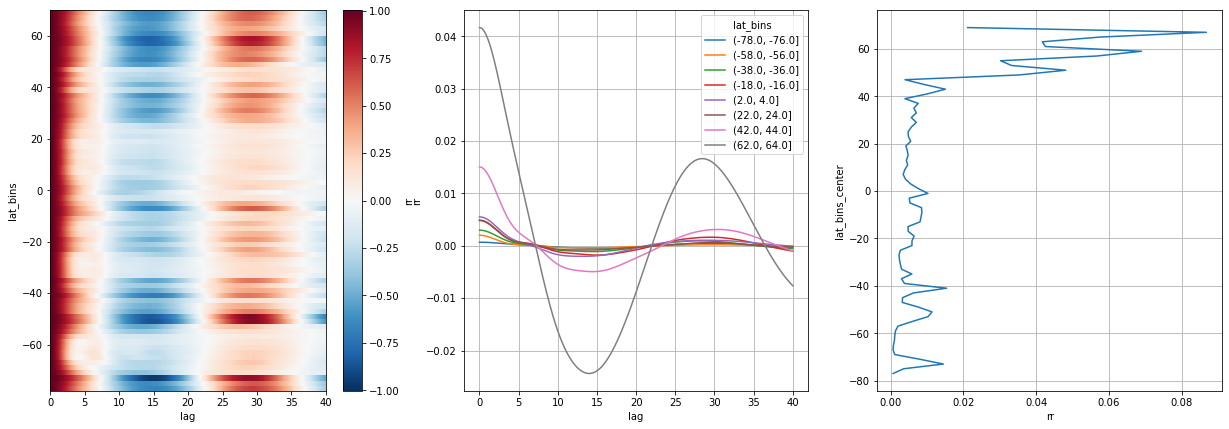

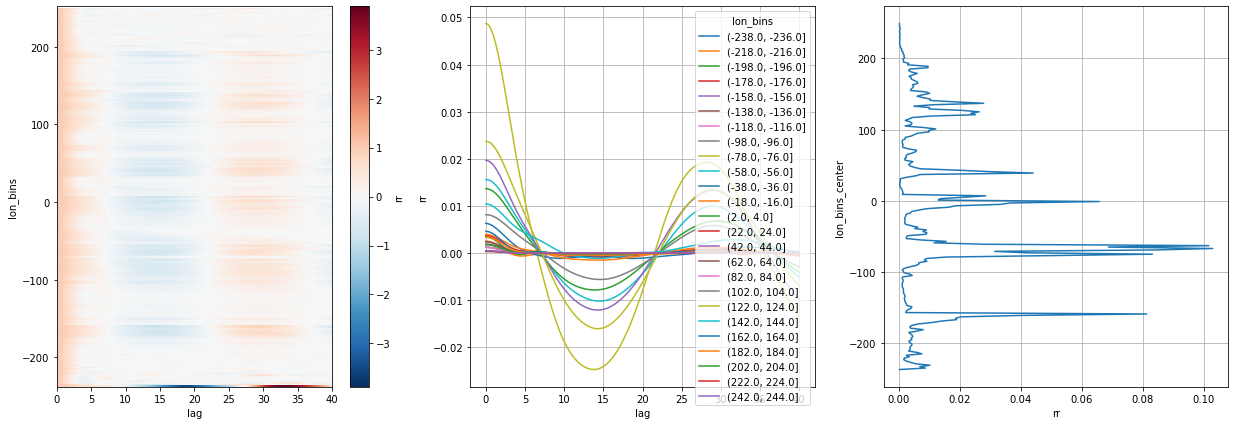

In [26]:
fig,ax = plt.subplots(1,3,figsize=(21,7))
(ds.mean('lon_bins')/ds.mean('lon_bins').isel(lag=0)).rr.plot(ax=ax[0])
(ds.mean('lon_bins').isel(lat_bins=slice(0,None,10))).rr.plot(ax=ax[1],hue='lat_bins')
ax[1].grid();
ds.mean('lon_bins').isel(lag=0).rr.plot(ax=ax[2],y='lat_bins');ax[2].grid();
ax[2].set_title('')
fig,ax = plt.subplots(1,3,figsize=(21,7))
(ds.mean('lat_bins')/ds.mean('lat_bins').isel(lag=0)).rr.plot(ax=ax[0])
(ds.mean('lat_bins').isel(lon_bins=slice(0,None,10))).rr.plot(ax=ax[1],hue='lon_bins')
ax[1].grid();
ds.mean('lat_bins').isel(lag=0).rr.plot(ax=ax[2],y='lon_bins');ax[2].grid();
ax[2].set_title('')

Text(0.5, 1.0, '')

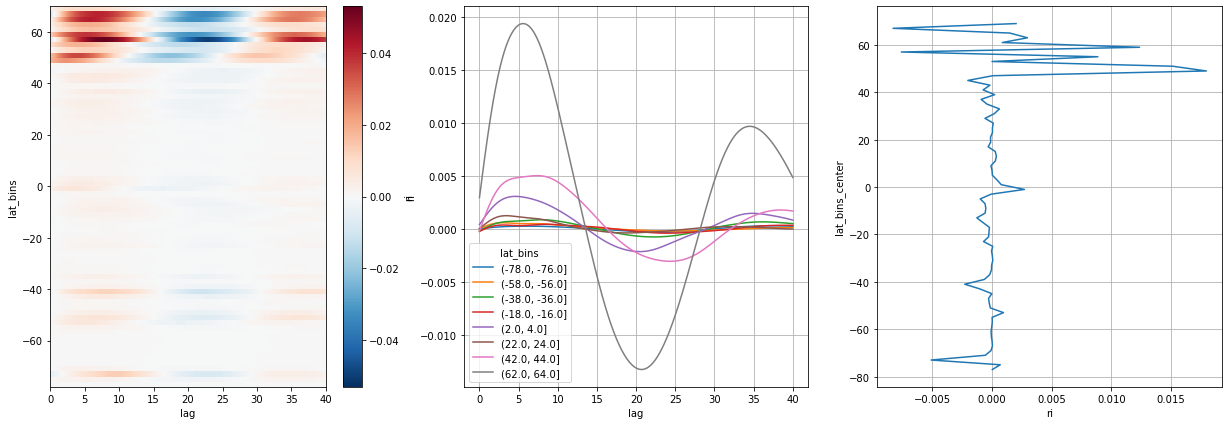

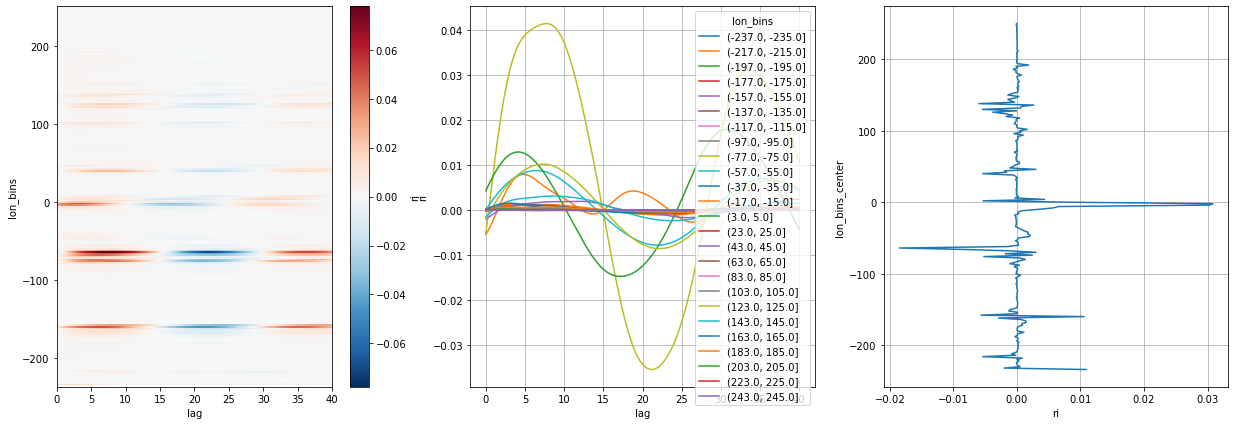

In [27]:
fig,ax = plt.subplots(1,3,figsize=(21,7))
(ds.mean('lon_bins')).ri.plot(ax=ax[0])
(ds.mean('lon_bins').isel(lat_bins=slice(0,None,10))).ri.plot(ax=ax[1],hue='lat_bins')
ax[1].grid();
ds.mean('lon_bins').isel(lag=0).ri.plot(ax=ax[2],y='lat_bins');ax[2].grid();
ax[2].set_title('')
fig,ax = plt.subplots(1,3,figsize=(21,7))
(ds.mean('lat_bins')).ri.plot(ax=ax[0])
(ds.mean('lat_bins').isel(lon_bins=slice(0,None,10))).ri.plot(ax=ax[1],hue='lon_bins')
ax[1].grid();
ds.mean('lat_bins').isel(lag=0).ri.plot(ax=ax[2],y='lon_bins');ax[2].grid();
ax[2].set_title('')

In [1]:
# Autocovariance at lag 0 (~$\widetilde{V}^2)
ds.isel(lag=0).rr.plot(y='lat_bins',vmax=1e-2)
plt.xlim(-180,180)

NameError: name 'ds' is not defined

In [4]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
